# Project 03: Clustering Human Recognition

Este proyecto busca detectar qué acción está realizando un humano por medio de un datasets de videos donde se realizan interacciones como: *tocar instrumentos, interacción de humanos con objetos, humanos saludándose, humanos abrazándose, etc*. Para cada acción se cuentan con como mínimo 400 video clips.

---
## 0. Libraries & setup

In [1]:
import os
import glob
import h5py

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.core.display import HTML
from matplotlib import rcParams

In [2]:
np.random.seed(11)
HTML("""<style>.output_png { display: table-cell; text-align: center; vertical-align: middle;}</style>""")
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 100
rcParams['grid.linewidth'] = 0.5

sns.set_palette(custom_colors)

---
## 1. Video features extraction

Cada clip tiene asociado con una sola acción humana y dura aproximadamente 10 sgundos. Este proyecto usa un subset del dataset original, se utilizará la librería de Video Fetures y Gluon para extraer las características del video.

Para proceder con el almacenamiento de los datos se utilizará un almacenamiento del tipo **HDF5** por medio de la librería `h5py`. De igual forma se procede a utiizar un modelo etiquetado como: **Action Recognition** para la extracción de características, esto es así pues a comparación del otro modelo **Frame-wise** nosotros tenemos como data acciones dinámicas y no estáticas.

El costo computacional para reconocimiento de acciones será más costoso pues analizará más frames por segundo, por ese motivo se elijió el modelo **R(2 + 1)D pre entrenado con Kinetics 400**, que si bien no es el más potente o el que brinda más características, pero si aquel que tiene un buen **tradeoff** entre eficiencia y precisión.

Necesitamos **extraer las características** de nuestros videos por medio de la librería que se ejecuta a nivel terminal, con el siguiente comando podremos transformar un listado de videos tal que obtenemos características para cada uno. Es así que contamos en la [documentación](https://v-iashin.github.io/video_features/models/s3d/) con argumentos opcionales, un ejemplo es el siguiente `python main.py feature_type = s3d video_paths="[./qyjw13RCjZk_000017_000027.mp4]" show_pred = true`

In [4]:
def extract_video_data(video_features_path, labels_df):
    video_features = []
    video_labels = []
    video_empty_frames = 0
    
    for each_video in glob.glob(os.path.join(video_features_path, '*.npy')):
        video_id = os.path.basename(each_video).split('_')[0]
        current_video_feature = np.load(each_video)

        if current_video_feature.size == 0:
            video_empty_frames += 1
            continue

        current_video_feature_avg = np.mean(current_video_feature, axis = 0)    
        video_features.append(current_video_feature_avg)

        current_video_label = labels_df[labels_df['video_id'] == video_id]['action'].values[0]
        video_labels.append(current_video_label)

    print(f'Número de videos vacíos no agregados ({video_features_path}): {video_empty_frames}')    
    
    video_features_stacked = np.vstack(video_features)
    video_labels_stacked = np.vstack(video_labels)
    
    df_features = pd.DataFrame(video_features_stacked)
    df_labels = pd.DataFrame(video_labels_stacked)

    return df_features, df_labels

df_train_labels = pd.read_csv('./data/train.csv', header = None, names = ['video_id', 'action'])
df_val_labels = pd.read_csv('./data/val.csv', header = None, names = ['video_id', 'action'])

X_train, Y_train = extract_video_data('./data/train_npy', df_train_labels)
X_train.dropna(inplace = True)
Y_train.dropna(inplace = True)

print(f'\nNúmero de videos cargados para entrenamiento: {len(X_train)}')
print(f'Shape de nuestra matriz de videos para entrenamiento: {X_train.shape}')

#X_val, Y_val = extract_video_data('./data/s3d/val', df_val_labels)
#X_val.dropna(inplace = True)
#Y_val.dropna(inplace = True)

#print(f'\nNúmero de videos cargados para validación: {len(X_val)}')
#print(f'Shape de nuestra matriz de videos para validación: {X_val.shape}')

Número de videos vacíos no agregados (./data/train_npy): 1

Número de videos cargados para entrenamiento: 2986
Shape de nuestra matriz de videos para entrenamiento: (2986, 512)


---
## 2. Data Exploration

Empezaremos creando un objeto dataframe donde vamos a enlazar lo obtenido en nuestra matriz de video con nuestros labels respectivamente que están **asociados al id** del video. De esta manera podemos visualizar nuestra información por medio de funciones como `describe()` ó `head()` inicialmente, para observar los datos obtenidos.

In [5]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.878798,2.127954,1.607034,0.664306,0.522798,1.013348,0.496048,0.670946,1.614572,0.556826,...,0.961463,0.735702,0.909073,0.504419,0.708933,1.451689,0.475423,0.565447,0.268131,0.542298
1,0.859695,0.256636,0.828024,0.762338,0.904630,0.388093,1.098017,0.656469,1.358928,0.394610,...,1.458510,0.812723,0.534491,0.825280,0.486746,0.408810,0.829993,0.357889,2.327460,1.175252
2,0.752613,0.471802,1.577832,0.240010,0.435650,2.282066,0.303541,0.310672,0.422906,0.275732,...,0.446387,0.587015,0.797592,0.929399,0.321831,1.770916,0.605534,0.248371,0.323492,1.066574
3,0.144510,0.798103,0.516781,0.447890,0.350492,0.269545,1.514265,0.522804,1.292049,1.096472,...,0.407084,0.691037,0.770490,0.804482,0.568932,0.629768,0.656983,0.705333,0.307782,1.231618
4,0.647730,0.841145,0.645143,0.334893,0.208868,0.703811,0.278712,0.593607,0.628390,2.401391,...,0.464922,0.574219,0.144682,0.440950,1.268292,0.434528,1.175014,0.233547,0.745130,0.462417


Si solicitamos las estadísticas descriptivas logramos observar para cada característica / feature su valor en media, cantidad de elementos, desviación estándar, mínimos, máximos, etc. En este caso todas nuestras columnas tienen $512$ elementos, por lo que no hay nulos. Además es posible notar que las medias son distintas, esto quiere decir que hay **diferentes puntos de activación para diferentes videos**. Es posible notar que el mínimo en casi todas las colummnas es $0$ lo que indica que hay características que en ciertos videos no están presentes o activadas.

In [6]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
count,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,...,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000
mean,0.786457,0.789431,0.726719,0.716137,0.909407,0.740036,0.825125,0.738011,0.934537,0.697296,...,0.943588,0.821066,0.846880,0.759490,0.858094,0.869712,0.947327,0.581758,0.817313,0.890151
std,0.515410,0.559258,0.492144,0.474330,0.530978,0.482153,0.557819,0.446788,0.615076,0.545679,...,0.621582,0.559256,0.525040,0.498825,0.540990,0.566872,0.618634,0.542296,0.608976,0.568125
min,0.040800,0.020453,0.011507,0.009543,0.012847,0.003607,0.033694,0.019506,0.018183,0.024630,...,0.025738,0.032935,0.010949,0.013889,0.020428,0.025323,0.016836,0.005921,0.016477,0.017315
25%,0.474871,0.423756,0.378656,0.385943,0.526051,0.408181,0.425824,0.422490,0.473687,0.326231,...,0.525384,0.443852,0.457681,0.424240,0.466673,0.474183,0.547493,0.271724,0.383369,0.493886
50%,0.683784,0.637352,0.588265,0.602261,0.798248,0.629253,0.674560,0.632748,0.791571,0.526217,...,0.803148,0.684381,0.726973,0.626763,0.744337,0.725435,0.804214,0.437844,0.639102,0.755484
75%,0.965278,0.965449,0.944417,0.930583,1.176169,0.952339,1.078616,0.940474,1.249697,0.889291,...,1.166081,1.032044,1.117871,0.973069,1.115397,1.102089,1.160050,0.691609,1.057922,1.123213
max,5.821651,4.477523,3.391186,3.498535,3.432921,3.987755,4.300030,3.271487,4.074717,4.074570,...,5.093231,4.462048,3.310855,3.832214,4.835620,4.356977,5.258881,4.762328,3.902226,3.985612


Ahora si utilizamos el `value_counts()` que indica la categoría y sus veces repetidas es posible notar la cantidad de veces que una clase se repite, de esa forma es posible **encontrar la más y menos repetida**, por ende la de mayor probabilidad de suceder y notar su distribución. Para mejorar su compresión de manera gráfica nos apoyamos de un gráfico de barras.

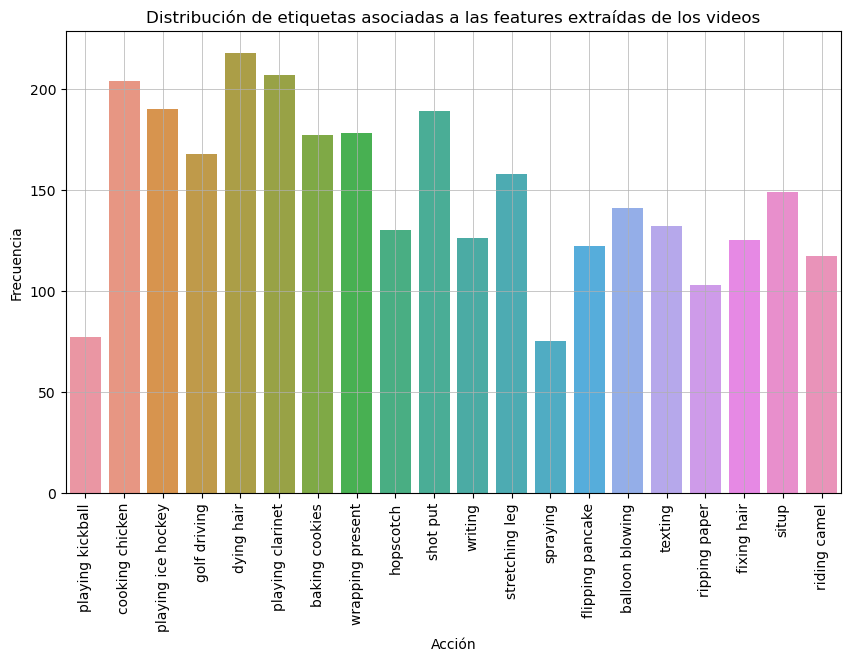

In [7]:
df_train = X_train.copy()
df_train['action'] = Y_train

sns.countplot(data = df_train, x = 'action')
plt.xlabel('Acción')
plt.ylabel('Frecuencia')
plt.title('Distribución de etiquetas asociadas a las features extraídas de los videos')
plt.xticks(rotation = 90)
plt.grid(True)
plt.show()

---
## 3. Dimensionality reduction

Usaremos **PCA (Principal Component Analysis)** que nos permitirá reducir la dimensionalidad manteniendo la mayor parte de la varianza de los datos, a mayor cantidad de varianza habrá mayor entropía por lo que por ende seguiremos contando con gran cantidad de **información representativa**. Para hallar la cantidad de componentes correcta usaremos dos métodos, el primero es representar gráficamente la relación que tienen los componentes con la varianza y encontrar una intersección que tenga buena cantidad de varianza y a la vez componentes necesarios.

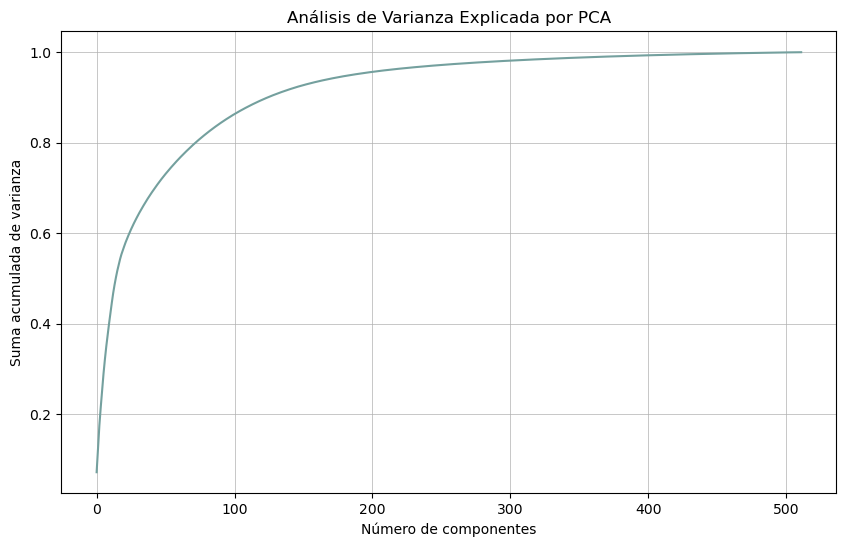

In [8]:
pca = PCA()
pca.fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Suma acumulada de varianza')
plt.title('Análisis de Varianza Explicada por PCA')
plt.grid(True)
plt.show()

Otro método para hallar las componentes es utilizar operaciones condicionales en numpy para **obtener aquellos índices donde se cumple una condición**, en este caso una cantidad determinada de varianza. Para ello aplicamos la función `np.where` con las condiciones. Evaluamos en un rango del $80\%$ al $90\%$ de modo que al final decantamos por el índice que represente un $\approx 90\%$ y se puede observar que se encuentra en el codo con una buena proporción.

In [9]:
pca_sum_variance = np.cumsum(pca.explained_variance_ratio_)

print('Indices que cumplen con varianza entre 80% a 90%')
print(np.where((pca_sum_variance > 0.80) & (pca_sum_variance < 0.90)))

n_principal_components = 73
print(f'\nNúmero de componentes elegido: {n_principal_components}')

Indices que cumplen con varianza entre 80% a 90%
(array([ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124]),)

Número de componentes elegido: 73


In [10]:
pca = PCA(n_components = n_principal_components)
X_train_reduced = pd.DataFrame(pca.fit_transform(X_train))

print(f"Varianza explicada con {n_principal_components} componentes: {np.sum(pca.explained_variance_ratio_):.2f}")
print(f'\nShape antesde aplicar PCA: {X_train.shape}')
print(f'Shape después de aplicar PCA: {X_train_reduced.shape}')

X_train_reduced.describe()

Varianza explicada con 73 componentes: 0.80

Shape antesde aplicar PCA: (2986, 512)
Shape después de aplicar PCA: (2986, 73)


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
count,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,...,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03,2.986000e+03
mean,1.903664e-17,1.047015e-16,8.328532e-17,4.759161e-17,-1.808481e-16,1.665706e-17,-4.759161e-17,-9.399343e-17,-2.855497e-17,2.141622e-17,...,-2.456917e-16,-4.176164e-16,-1.844175e-16,2.320091e-16,-2.445019e-16,1.511034e-16,-4.580692e-16,1.368259e-16,3.379004e-16,6.139318e-16
std,3.304474e+00,2.871436e+00,2.776070e+00,2.492189e+00,2.379749e+00,2.375326e+00,2.202235e+00,2.093742e+00,1.990358e+00,1.936639e+00,...,6.813918e-01,6.776198e-01,6.720145e-01,6.645948e-01,6.629819e-01,6.565134e-01,6.544349e-01,6.501201e-01,6.391711e-01,6.282239e-01
min,-7.949696e+00,-9.460986e+00,-8.114744e+00,-5.393086e+00,-6.140254e+00,-6.722109e+00,-8.170477e+00,-5.445721e+00,-5.967830e+00,-7.596799e+00,...,-2.253952e+00,-2.240699e+00,-2.576693e+00,-2.521839e+00,-2.965690e+00,-2.434980e+00,-2.270209e+00,-2.986195e+00,-2.733988e+00,-3.098993e+00
25%,-2.568091e+00,-1.552109e+00,-1.948530e+00,-1.644848e+00,-1.725228e+00,-1.268890e+00,-1.299757e+00,-1.436484e+00,-1.354576e+00,-1.237583e+00,...,-4.059542e-01,-4.217002e-01,-4.285385e-01,-4.033884e-01,-4.164658e-01,-4.279339e-01,-4.227156e-01,-4.184972e-01,-4.027564e-01,-3.935054e-01
50%,9.931078e-02,2.354635e-01,-6.674298e-02,-3.575988e-01,-3.321774e-01,1.611809e-01,-2.333830e-01,2.435789e-02,-2.067901e-01,-5.674538e-02,...,1.349697e-02,1.261994e-03,1.518936e-02,1.145418e-02,-1.275769e-03,-1.048980e-02,1.469134e-03,-3.109939e-03,-1.879507e-03,-2.346449e-03
75%,2.903162e+00,1.929403e+00,1.388679e+00,1.208838e+00,1.819360e+00,1.514544e+00,1.026507e+00,1.424142e+00,1.167031e+00,1.160821e+00,...,4.080672e-01,4.459904e-01,4.322063e-01,4.136500e-01,4.293646e-01,4.283560e-01,4.235501e-01,3.917366e-01,3.863622e-01,3.908899e-01
max,9.396282e+00,1.096423e+01,1.032879e+01,1.077395e+01,8.872747e+00,8.196585e+00,8.987861e+00,7.468888e+00,9.332745e+00,8.816033e+00,...,2.909640e+00,2.694084e+00,2.639023e+00,3.088858e+00,3.134508e+00,2.897447e+00,2.478426e+00,3.420829e+00,3.512085e+00,3.107329e+00


Ahora procedemos a escalar nuestros datos una vez contamos con nuestro eje X de entrenamiento reducido, esto nos va permitir poder trabajar con aquellos outliers (valores extremos) y demás puntos con una escala tal que en la medida que sea posible, todas las características contribuyan equitativamente al análisis del clustering. Es posible notar esto en el gráfico presentado en la parte inferior, antes y después del aplicado del escalado usando la función `RobustScaler()` adecuado cuando existen muchos outliers, como es este caso.

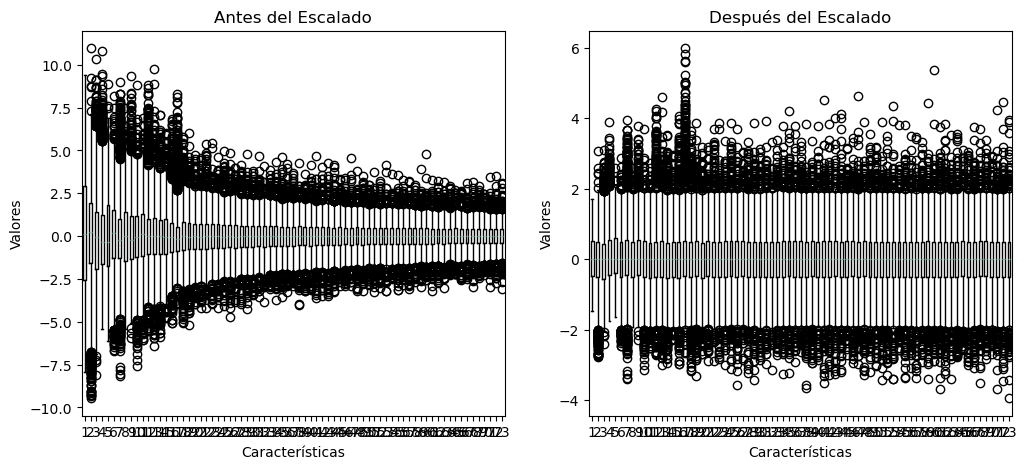

In [11]:
scaler = RobustScaler()
X_train_robust_scaled = scaler.fit_transform(X_train_reduced)

_, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].boxplot(X_train_reduced)
ax[0].set_title('Antes del Escalado')
ax[0].set_xlabel('Características')
ax[0].set_ylabel('Valores')

ax[1].boxplot(X_train_robust_scaled)
ax[1].set_title('Después del Escalado')
ax[1].set_xlabel('Características')
ax[1].set_ylabel('Valores')

plt.grid(False)
plt.show()

A continuación se va utilizar el método del codo, o más conocido como **Elbow Plot** que nos va permitir identificar el **número óptimo de clusters**, nos permite medir la inercia que indica qué tan bien fue clusterizada la información usando el algoritmo **K-Means** comparado con una cantidad $k$ de clusters. Se busca el punto de inflexión donde la inercia empieza a reducirse.

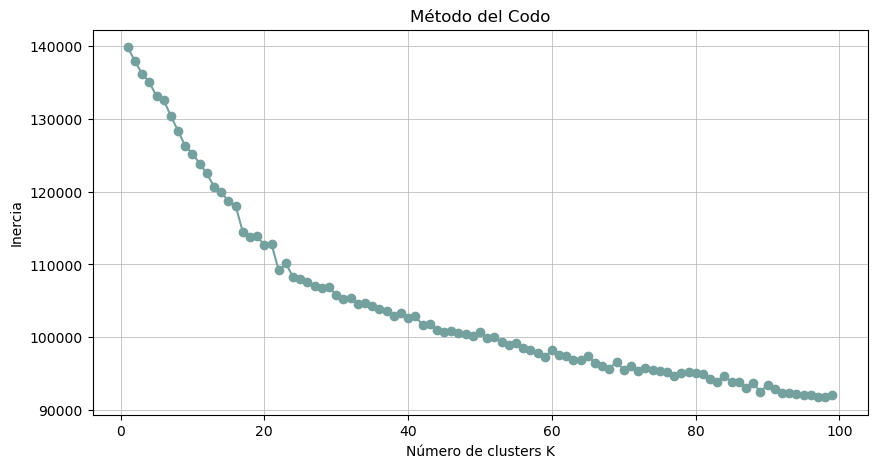

In [13]:
def k_means_optimize(data, max_range_k):
    means_list = []
    inertias_list = []
    
    for current_k in range(1, max_range_k):
        kmeans = KMeans(n_clusters = current_k)
        kmeans.fit(data)
        
        means_list.append(current_k)
        inertias_list.append(kmeans.inertia_)

    fig = plt.subplots(figsize = (10, 5))
    plt.plot(means_list, inertias_list, 'o-')
    plt.title('Método del Codo')
    plt.xlabel('Número de clusters K')
    plt.ylabel('Inercia')
    plt.grid(True)
    plt.show()

#print(f'Número de clusters elegido por referencia de ElbowPlot: {k_decision_clusters}')
k_decision_clusters = 40
k_means_optimize(X_train_robust_scaled, 100)

In [ ]:
k = 20

kmeans = KMeans(n_clusters= k)
kmeans.fit(X_train_robust_scaled)
print(kmeans.labels_)

score = silhouette_score(X_train_robust_scaled, kmeans.labels_)
print(f"Silhouette Score para k={k}: {score:.2f}")

# Visualización de clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title(f'Visualización de Clusters para k={k}')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.colorbar()
plt.show()

---
### 3. Clustering methods

#### 3.1 Partitioning Method: Median Shift
---
Probando con librerías existentes para ver si se adecuan los datos correctamente

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, mutual_info_score
from sklearn.preprocessing import RobustScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Supongamos que tus datos ya están cargados y escalados en X_train_robust_scaled

# DBSCAN Clustering
dbscan = DBSCAN(eps=11, min_samples=73*2)
clusters_dbscan = dbscan.fit_predict(X_train_robust_scaled)
print(clusters_dbscan)

# Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=20)
clusters_agglo = agglomerative.fit_predict(X_train_robust_scaled)

# KMeans Clustering
kmeans = KMeans(n_clusters=20, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_train_robust_scaled)

# Calcular el Silhouette Score para cada clustering
silhouette_dbscan = silhouette_score(X_train_robust_scaled, clusters_dbscan) if np.unique(clusters_dbscan).size > 1 else -1
silhouette_agglo = silhouette_score(X_train_robust_scaled, clusters_agglo)
silhouette_kmeans = silhouette_score(X_train_robust_scaled, clusters_kmeans)

print(f"Silhouette Score para DBSCAN: {silhouette_dbscan}")
print(f"Silhouette Score para Clustering Jerárquico: {silhouette_agglo}")
print(f"Silhouette Score para KMeans: {silhouette_kmeans}")

# Visualización con t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_robust_scaled)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# DBSCAN
axs[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_dbscan, cmap='viridis', edgecolor='k', alpha=0.7)
axs[0].set_title('DBSCAN Clustering')
axs[0].set_xlabel('Componente t-SNE 1')
axs[0].set_ylabel('Componente t-SNE 2')

# Agglomerative
axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_agglo, cmap='viridis', edgecolor='k', alpha=0.7)
axs[1].set_title('Agglomerative Clustering')
axs[1].set_xlabel('Componente t-SNE 1')

# KMeans
axs[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_kmeans, cmap='viridis', edgecolor='k', alpha=0.7)
axs[2].set_title('KMeans Clustering')
axs[2].set_xlabel('Componente t-SNE 1')

plt.tight_layout()
plt.show()


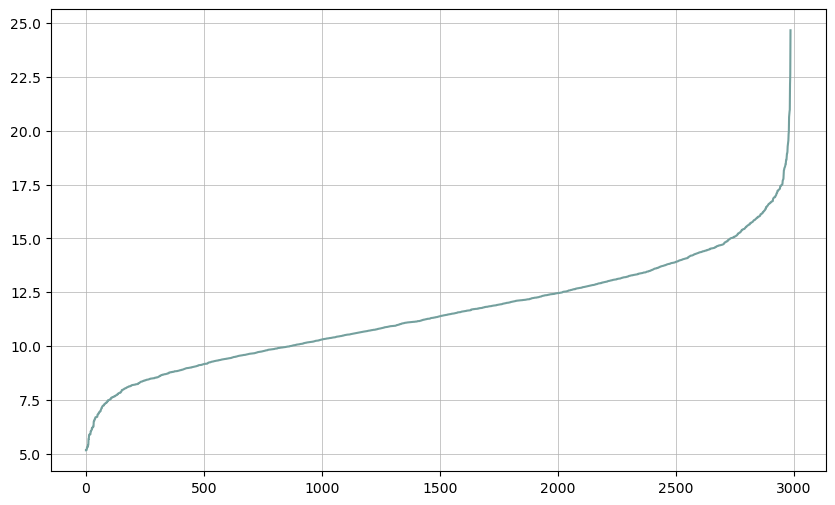

In [28]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

n = 73

neighbors = NearestNeighbors(n_neighbors=n)
neighbors_fit = neighbors.fit(X_train_reduced)
distances, indices = neighbors_fit.kneighbors(X_train_reduced)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.grid(True)
plt.show()

#### 3.1 Density-based Method: DBSCAN
---
TODO


Shape antesde aplicar PCA: (2986, 512)
Shape después de aplicar PCA: (2986, 73)
[0 0 0 ... 0 0 0]
Silhouette Score para DBSCAN: 0.30336566490376116
Silhouette Score para Clustering Jerárquico: 0.20759297030436002
Silhouette Score para KMeans: 0.16875435804134548


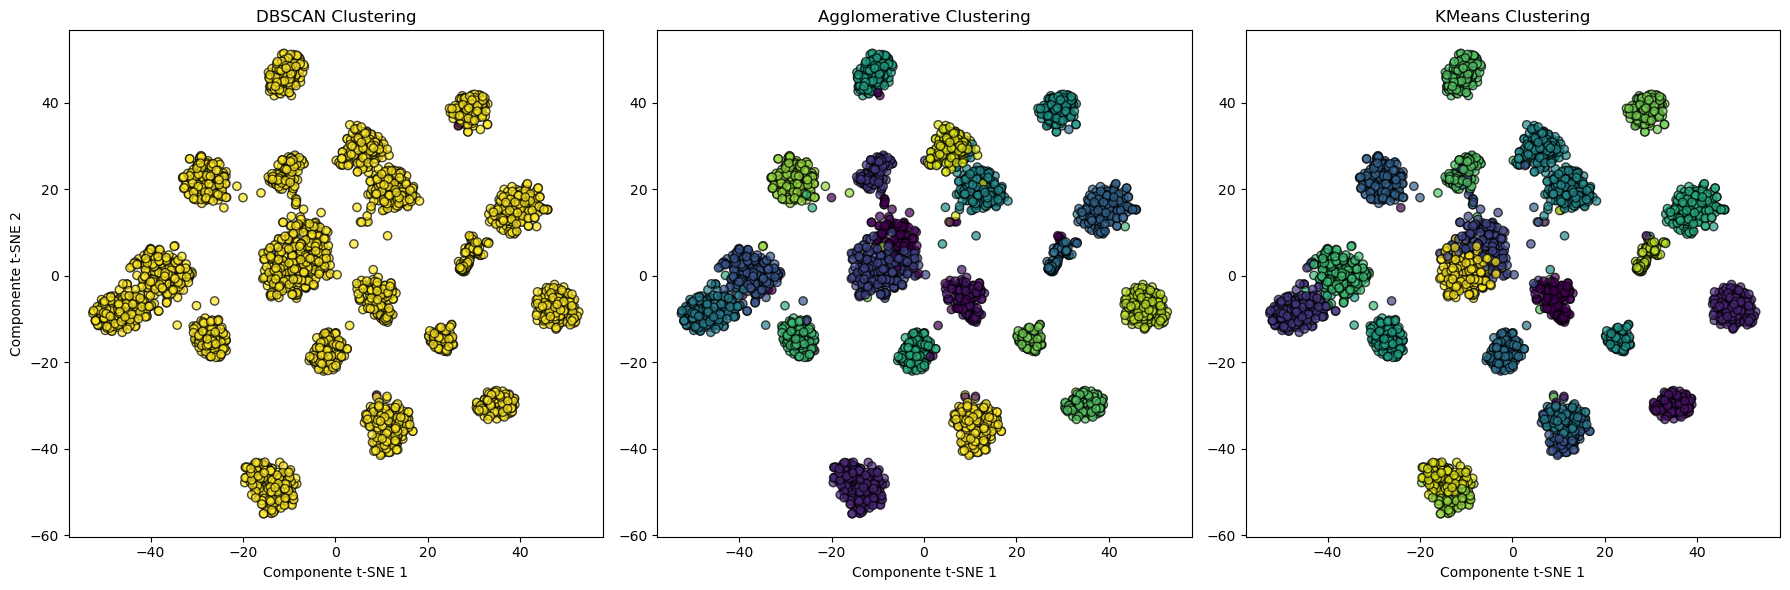

In [41]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, mutual_info_score
from sklearn.preprocessing import RobustScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

scaler = RobustScaler()
X_train_robust_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components = 73)
X_train_reduced = pd.DataFrame(pca.fit_transform(X_train_robust_scaled))

print(f'\nShape antesde aplicar PCA: {X_train.shape}')
print(f'Shape después de aplicar PCA: {X_train_reduced.shape}')

dbscan = DBSCAN(eps=24, min_samples=73)
clusters_dbscan = dbscan.fit_predict(X_train_reduced)
print(clusters_dbscan)

# Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=20)
clusters_agglo = agglomerative.fit_predict(X_train_reduced)

# KMeans Clustering
kmeans = KMeans(n_clusters=20, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_train_reduced)

# Calcular el Silhouette Score para cada clustering
silhouette_dbscan = silhouette_score(X_train_reduced, clusters_dbscan) if np.unique(clusters_dbscan).size > 1 else -1
silhouette_agglo = silhouette_score(X_train_reduced, clusters_agglo)
silhouette_kmeans = silhouette_score(X_train_reduced, clusters_kmeans)

print(f"Silhouette Score para DBSCAN: {silhouette_dbscan}")
print(f"Silhouette Score para Clustering Jerárquico: {silhouette_agglo}")
print(f"Silhouette Score para KMeans: {silhouette_kmeans}")

# Visualización con t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_reduced)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# DBSCAN
axs[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_dbscan, cmap='viridis', edgecolor='k', alpha=0.7)
axs[0].set_title('DBSCAN Clustering')
axs[0].set_xlabel('Componente t-SNE 1')
axs[0].set_ylabel('Componente t-SNE 2')

# Agglomerative
axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_agglo, cmap='viridis', edgecolor='k', alpha=0.7)
axs[1].set_title('Agglomerative Clustering')
axs[1].set_xlabel('Componente t-SNE 1')

# KMeans
axs[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_kmeans, cmap='viridis', edgecolor='k', alpha=0.7)
axs[2].set_title('KMeans Clustering')
axs[2].set_xlabel('Componente t-SNE 1')

plt.tight_layout()
plt.show()


---
### 4. Classification metrics

TODO